# Lesson 1 - Introduction to random forests

> A first look at training Random Forest models to identify τ → μμμ decays

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/hepml/master?urlpath=lab/tree/notebooks%2Flesson01_intro-to-random-forests.ipynb)

## Learning objectives

* Gain an introduction to the pandas library
* Understand the main steps involved in training a machine learning model
* Gain an introduction to scikit-learn's API
* Understand the need to generate a training and validation set

## References

* Chapters 2 & 3 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron

## The data

We will be analysing data from the Kaggle competition [Flavours of Physics: Finding τ → μμμ](https://www.kaggle.com/c/flavours-of-physics/overview). As described on the Kaggle webpage:

> In this competition, you are given a list of collision events and their properties. You will then predict whether a τ → 3μ decay happened in this collision. This τ → 3μ is currently assumed by scientists not to happen, and the goal of this competition is to discover τ → 3μ happening more frequently than scientists currently can understand.

Framed as a supervised learning task, our goal is thus to train a model that is capable of distinguishing signal from background events, given physical input values.

There are 4 datasets associated with this challenge, namely:

* **train.csv:** This is a labelled dataset (the label `signal` being `1` for signal events, `0` for background events) to train the classifier. Signal events have been simulated, while background events are real data.
* **test.csv:** The test dataset has all the columns that training.csv has, except `mass`, `production`, `min_ANNmuon`, and `signal`. 
* **check_agreement.csv:** This dataset contains simulated and real events from the Control channel Ds → φπ to evaluate your simulated-real data of submission agreement locally.
* **check_correlation.csv:** This dataset contains only real background events recorded at LHCb to evaluate your submission correlation with mass locally.

## Import libraries

In [ ]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
from pathlib import Path
from hepml.core import display_large, download_dataset

# data viz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_roc_curve

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from hepml.evaluation import roc_auc_truncated, compute_ks, compute_cvm

## Load the data

First we need to fetch the datasets from Google Drive - we can do that by running the following function:

In [ ]:
download_dataset("tau_decays_train.csv")
download_dataset("tau_decays_test.csv")

Dataset already exists at '../data/tau_decays_train.csv' and is not downloaded again.
Dataset already exists at '../data/tau_decays_test.csv' and is not downloaded again.


To load our dataset we need to tell pandas where to look for it. First, lets have a look at what we have in the `data/` directory:

In [ ]:
DATA = Path("../data")
!ls {DATA}

hb_submission.csv                tau_decays_check_correlation.csv
rf_submission.csv                tau_decays_test.csv
tau_decays_check_agreement.csv   tau_decays_train.csv


With pathlib it is a simple matter to define the filepath to the train and test datasets, and since the files are in CSV format we can load it as a `pandas.DataFrame` as follows:

In [ ]:
train = pd.read_csv(DATA / "tau_decays_train.csv")
test = pd.read_csv(DATA / "tau_decays_test.csv")

## Inspect the data

### Preview the data

This first thing you should do after creating a `pandas.DataFrame` is to inspect the first/last few rows to make sure there's no surprises in the data format that need to be dealt with. For example, one often finds metadata or aggregations at the end of CSV/Excel files, and this can cause problems if not handled correctly.

The `DataFrame.head` method displays the _first_ five rows of a `pandas.DataFrame`:

In [ ]:
train.head()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


If we want to see more rows, we just pass an integer argument to the method as follows:

In [ ]:
train.head(10)

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060
5,18316844,0.000819,0.995340,3.638690,0.250140,0.232313,12.628694,13.217284,1452.949585,0.105752,...,12886.835938,8040.938477,3.673540,3.150380,2.974392,258,-99,0,1823.130981,0.272359
6,16522942,0.005190,0.999985,38.920113,0.151273,0.216020,15.352684,1.700249,3912.482666,0.006991,...,24599.054688,10370.023438,2.495311,3.306201,2.926639,358,-99,0,1665.762939,0.229626
7,3341177,0.000632,0.999601,4.127854,0.149296,0.115681,10.482354,10.820628,7682.583008,0.052060,...,20122.953125,8500.297852,2.179665,2.471615,2.449492,292,-99,0,1930.380981,0.370381
8,13870233,0.001652,0.999876,11.274630,0.320217,0.177103,8.269794,3.301484,3796.261719,0.079522,...,10330.231445,24728.355469,3.445711,2.545625,3.273179,222,-99,0,1839.758057,0.348409
9,17913585,0.001048,0.999771,8.732768,0.754453,0.268545,11.076645,5.844945,1901.681274,0.041319,...,15422.355469,25520.925781,3.986849,3.874437,3.473346,454,-99,0,1809.005981,0.269867


Similar to `DataFrame.head`, the `DataFrame.tail` method returns the _last_ five rows of a `pandas.DataFrame`:

In [ ]:
train.tail()

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
67548,8697118,0.002119,0.999994,13.959758,0.218555,0.048056,4.228432,2.259959,4448.312500,0.050823,...,21479.021484,11186.428711,3.243758,2.662427,2.909159,236,5,1,1778.930176,0.613175
67549,16518324,0.002150,0.999994,17.951668,0.362415,0.059266,4.356027,1.288439,4094.758545,0.027567,...,33156.484375,7878.073730,2.891281,3.163634,3.220385,461,1,1,1784.219360,0.700559
67550,8826363,0.000969,0.999954,5.089369,0.250686,0.051560,2.790214,1.725869,2481.475830,0.057835,...,11928.290039,10929.805664,3.189317,3.259355,2.774369,125,5,1,1781.661987,0.316008
67551,13463112,0.001296,0.999996,18.405382,0.580693,0.051905,3.617818,0.454716,3977.924561,0.035837,...,46318.148438,24221.369141,4.326723,3.802581,3.336862,88,1,1,1781.596558,0.597442
67552,16716947,0.000550,0.999966,3.726029,0.281888,0.031183,2.172310,3.116862,3298.051025,0.024616,...,17293.789062,10099.850586,3.095043,3.226203,2.850009,137,1,1,1772.682983,0.602006


One problem with the above previews is that the dataset has too many columns and `DataFrame.head` just shows `...` for intermediate columns. To fix that we can configure the [options in pandas](https://pandas.pydata.org/pandas-docs/version/0.15/options.html) which we can wrap inside a simple function:

In [ ]:
display_large(train.head())

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,DOCAthree,IP_p0p2,IP_p1p2,isolationa,isolationb,isolationc,isolationd,isolatione,isolationf,iso,CDF1,CDF2,CDF3,ISO_SumBDT,p0_IsoBDT,p1_IsoBDT,p2_IsoBDT,p0_track_Chi2Dof,p1_track_Chi2Dof,p2_track_Chi2Dof,p0_IP,p1_IP,p2_IP,p0_IPSig,p1_IPSig,p2_IPSig,p0_pt,p1_pt,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,0.083660,0.208855,0.074343,8,5,7,1.0,0.0,3.0,4.0,0.473952,0.349447,0.329157,-0.579324,-0.256309,-0.215444,-0.107570,1.921700,0.866657,1.230708,0.988054,0.601483,0.277090,16.243183,4.580875,5.939936,353.819733,448.369446,1393.246826,3842.096436,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,0.030784,0.336345,0.173161,7,12,2,0.0,1.0,1.0,2.0,0.325785,0.265939,0.192599,-0.873926,-0.223774,-0.224871,-0.425281,0.958776,0.858357,1.810709,0.098752,0.219099,0.614524,3.610463,15.555593,11.238523,656.524902,2033.918701,747.137024,8299.368164,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,0.096829,0.169165,0.079789,1,0,1,0.0,0.0,0.0,0.0,1.000000,0.786482,0.557760,-0.479636,-0.202451,-0.100762,-0.176424,0.720973,1.408519,1.038347,0.186143,0.215668,0.371820,4.851371,11.590331,13.723293,658.523743,2576.380615,963.652466,11323.134766,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,0.006417,0.044816,0.050989,0.068167,2,2,4,0.0,0.0,0.0,0.0,1.000000,0.501195,0.501195,-0.439453,-0.162267,-0.176424,-0.100762,1.172767,2.044164,0.811454,0.255752,0.210698,0.392195,7.292110,8.778173,16.462036,1047.216187,1351.734131,1685.003662,11502.081055,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,0.037326,0.019026,0.172065,0.131732,0,2,0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.639926,-0.822285,-0.291524,-0.261078,-0.269682,1.523252,0.435325,0.581312,0.270755,0.183355,0.630763,6.783962,3.342091,17.252840,1442.538208,1755.792236,1282.428711,74117.117188,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


### The shape of data

Whenever we have a new dataset it is handy to begin by getting an idea of how large the `pandas.DataFrame` is. This can be done with either the `len` or `DataFrame.shape` methods:

In [ ]:
# get number of rows
len(train), len(test)

(67553, 855819)

In [ ]:
# get tuples of (n_rows, n_columns)
train.shape, test.shape

((67553, 51), (855819, 47))

Curiously, the test set has over 10 times more events than the training set 🤔. Looking at the data description on [Kaggle](https://www.kaggle.com/c/flavours-of-physics/data) we see that the test set is actually composed of several types of events

> * simulated signal events for the τ → 3μ
> * real background data for the τ → 3μ
> * simulated events for the control channel, (ignored for scoring, used by agreement test)
> * real data for the control channel (ignored for scoring, used by agreement test)

which may explain the unusually large test set.

### Unique values

Whenever we see an ID column like `id`, it is useful to perform a sanity check that each value is unique. Otherwise it may be possible that you have duplicates in your data that can bias your models and hence conclusions. 

In [ ]:
train["id"].nunique(), test["id"].nunique()

(67553, 855819)

Good! The number of unique IDs matches the number of rows in our train and test sets.

### Info
The `DataFrame.info` method is useful to get a quick description of the data, in particular the total number of row, and each column's type and number of non-null values.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67553 entries, 0 to 67552
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   67553 non-null  int64  
 1   LifeTime             67553 non-null  float64
 2   dira                 67553 non-null  float64
 3   FlightDistance       67553 non-null  float64
 4   FlightDistanceError  67553 non-null  float64
 5   IP                   67553 non-null  float64
 6   IPSig                67553 non-null  float64
 7   VertexChi2           67553 non-null  float64
 8   pt                   67553 non-null  float64
 9   DOCAone              67553 non-null  float64
 10  DOCAtwo              67553 non-null  float64
 11  DOCAthree            67553 non-null  float64
 12  IP_p0p2              67553 non-null  float64
 13  IP_p1p2              67553 non-null  float64
 14  isolationa           67553 non-null  int64  
 15  isolationb           67553 non-null 

Luckily for us, it looks like we're dealing with purely numeric data types and there's no missing values 🥳🥳🥳! Let's verify the latter is indeed true:

In [ ]:
assert train.isnull().sum().sum() == 0
assert test.isnull().sum().sum() == 0

## A first look a data visualisation

Another quick way to get a feel for the type of numeric data that you are dealing with is to plot one or more of the following:

* **Histograms:** shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). Useful for understanding the _shape_ of a single variable.
* **Count plots:** shows the counts of observations in each categorical bin using bars. A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable.

To create these plots we will use the [seaborn](https://seaborn.pydata.org/) data visualisation library. In the same way the `pd` is the accepted alias for pandas, one use `sns` as the alias for seaborn.

### Histograms

Histograms are one of the most simple, yet powerful types of data visualisation. They can quickly tell us which values are most frequent, whether there are outliers and more. To create a histogram in seaborn, we can use the `seaborn.distplot` method:

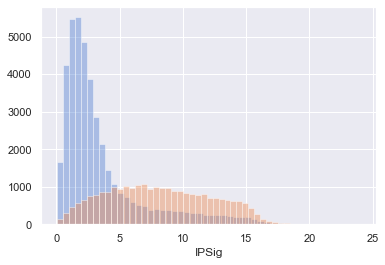

In [ ]:
sns.distplot(train.query("signal == 1")["IPSig"], kde=False)
sns.distplot(train.query("signal == 0")["IPSig"], kde=False)
plt.show()

Doing this manually for each feature of interest is tiresome, so let's write a simple function that genelaralises the process:

In [ ]:
def plot_histogram(feature_name: str, df: pd.DataFrame):
    sns.distplot(df.query("signal == 1")[feature_name], label="Signal", kde=False)
    sns.distplot(df.query("signal == 0")[feature_name], label="Background", kde=False)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.show()

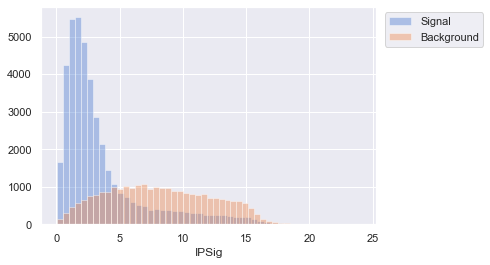

In [ ]:
plot_histogram("IPSig", train)

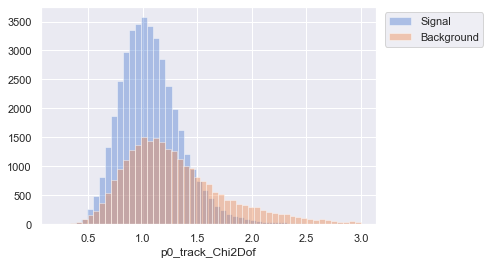

In [ ]:
plot_histogram("p0_track_Chi2Dof", train)

### Count plots

Count plots are handy when you have a categorical feature like `signal` and you want to quickly see the frequencies per category: 

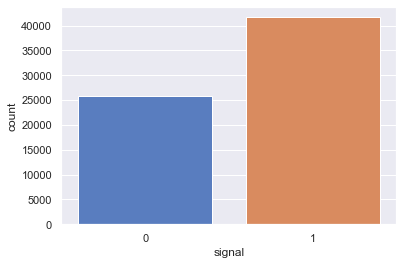

In [ ]:
sns.countplot(x="signal", data=train)
plt.show()

In [ ]:
train["signal"].value_counts(normalize=True)

1    0.616908
0    0.383092
Name: signal, dtype: float64

From the plot and numbers we see that the "signa" and "background" classes appear in approximately a 3:2 ratio. If we built a dumb classifier that just classifies every single event as "signal", then we would be right about 61.6% of the time! As we shall see below, this shows why accuracy is _**not**_ the preferred performance measures for classifiers, especially when you are dealing with _**skewed datasets**_.

## Feature engineering

Before we prepare the data for training machine learning models, it is useful to experiment with creating new features that may provide more information than the raw data alone. For example, we might want to include the ratio of the flight distance and the error:

In [ ]:
train['flight_distance_over_error'] = train['FlightDistance'] / train['FlightDistanceError']

Similarly, we might want to extract the maximum quality of the muon tracks:

In [ ]:
train["p_track_Chi2Dof_max"] = train.loc[:, ["p0_track_Chi2Dof", "p1_track_Chi2Dof", "p2_track_Chi2Dof"]].max(axis=1)

Let's wrap these steps into a simple function:

In [ ]:
def add_features(df):
    df["flight_distance_over_error"] = df["FlightDistance"] / df["FlightDistanceError"]
    df["p_track_Chi2Dof_max"] = df.loc[:, ["p0_track_Chi2Dof", "p1_track_Chi2Dof", "p2_track_Chi2Dof"]].max(axis=1)
    return df

In [ ]:
train = add_features(train)
test = add_features(test)

In [ ]:
# sanity check
train.head(1)

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon,flight_distance_over_error,p_track_Chi2Dof_max
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,3.076006,4.0038,4.031514,458,-99,0,1866.300049,0.277559,20.594827,1.9217


## Dropping columns

As explained in the Kaggle [docs](https://www.kaggle.com/c/flavours-of-physics/data)

> The test dataset has all the columns that training.csv has, except mass, production, min_ANNmuon, and signal. 

so we need to remove these columns to prevent [**data leakage**](https://www.kaggle.com/dansbecker/data-leakage), where a model is trained on features that are not present in the test data. 

<div style="text-align: center">
<img src='images/data_leakage.png'>
<p style="text-align: center;"> <b>Figure reference:</b> https://www.kaggle.com/dansbecker/data-leakage </p>
</div>

One way to remove unwanted columns is via the `DataFrame.drop()` method, so let's remove these 3 columns from the training set, along with `SPDHits` which is described in the competition [forum](https://www.kaggle.com/c/flavours-of-physics/discussion) as causing problems in the final evaluation:

In [ ]:
cols_to_drop = ["mass", "production", "min_ANNmuon", "SPDhits"]
train.drop(columns=cols_to_drop, axis=1, inplace=True)

> Note: You will often encounter the cryptic axis parameter when dealing with `pandas.DataFrame` and `pandas.Series` objects. This parameter is used to specify along which dimension we want to apply a given transformation - see the figure below for a graphical representation.

<div style="text-align: center">
<img src='./images/dataframe-series-axes.png' width='700'>
<p style="text-align: center;"> <b>Figure:</b> Visualisation of the <code>axis</code> parameter in pandas. </p>
</div>

## Introducing scikit-learn

Now that we've checked that the training data is clean and free from obvious anomalies, it's time to train our model! To do so, we will make use of the scikit-learn library.

scikit-learn is one of the best known Python libraries for machine learning and provides efficient implementations of a large number of common algorithms. It has a uniform _Estimator API_ as well as excellent online documentation. The main benefit of its API is that once you understand the basic use and syntax of scikit-learn for one type of model, switching to a new model or algorithm is very easy.

**Basics of the API**

The most common steps one takes when building a model in scikit-learn are:
1. Choose a class of model by importing the appropriate estimator class from scikit-learn.
2. Choose model _hyperparameters_ by instantiating this class with the desired values.
3. Arrange data into a feature matrix and target vector (see discussion below).
4. Fit the model to your data by calling the `fit()` method.
5. Evaluate the predictions of the model:
    * For supervised learning we typically predict _labels_ for new data using the `predict()` method.
    * For unsupervised learning, we often transform or infer properties of the data using the `transform()` or `predict()` methods.
    
Let's go through each of these steps to build a Random Forest regressor to predict California housing prices.

### Choose a model

In scikit-learn, every class of model is represented by a Python class. We want a Random Forest classifier, so looking at the online [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) we should import the `RandomForestClasifier`:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Choose hyperparameters

Once we have chosen our model class, there are still some options open to us:

* What is the maximum depth of the tree? The default is `None` which means the nodes are expanded until all leaves are pure.
* Other parameters can be found in the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier), but for now we take a simple model with just 20 trees.

The above choices are often referred to as _hyperparameters_ or parameters that must be set before the model is fit to the data. We can instantiate the `RandomForestClassifier` class and specify the desired hyperparameters as follows:

In [ ]:
model = RandomForestClassifier(n_estimators=20, n_jobs=-1)

### Arrange data into a feature matrix and target vector

scikit-learn requires that the data be arranged into a two-dimensional feature matrix and a one-dimensional target array. By convention: 

* The feature matrix is often stored in a variable called `X`. This matrix is typically two-dimensional with shape `[n_samples, n_features]`, where `n_samples` refers to the number of rows (i.e. events in our case) and `n_features` refers to all columns except `signal` which is our target.
* The target or label array is usually denoted by `y`.

In [ ]:
X = train.drop("signal", axis=1)
y = train["signal"]

### Fit the model to your data

Now it is time to apply our model to data! This can be done with the `fit()` method:

In [ ]:
model.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

### Evaluate the predictions

The final step is to generate predictions and evaluate them against some performance metric, e.g. accuracy:

In [ ]:
preds = model.predict(X)
accuracy_score(y, preds)

0.9977499148816484

Wait, wat!? How can the Random Forest model have almost no error at all? Is this a perfect model? Of course it is much more likely that the model has badly overfit the data. To be sure we need to use part of the training set for training and part for model validation.

> Warning: Evaluating our model's predictions on the same data it was trained on is almost always a recipe for disaster! Why? The problem is that the model may memorise the structure of the data it sees and fail to provide good predictions when shown new data.

## Better evaluation using training and validation splits

One way to measure how well a model will generalise to new cases is to split your data into two sets: the _**training set**_ and the _**validation set**_. As these names imply, you train your model using the training set and validate it using the validation set. The error rate on new cases is called the _**generalisation error**_ and by evaluating your model on the validation set, you get an estimation of this error.

Creating a validation set is theoretically quite simple: just pick some instances randomly and set them aside (we set the random number generator's seed `random_state` so that is always generates the same shuffled indices):

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

print(f"Dataset split: {len(X_train)} train rows + {len(X_valid)} valid rows")

Dataset split: 54042 train rows + 13511 valid rows


## Baseline model

With these two datasets, we first fit on the training set and evaluate the prediction on the validation one. To simplify the evaluation of our models, let's write a simple function to keep track of the scores:

In [ ]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [ ]:
model = RandomForestClassifier(n_estimators=20, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
print_scores(model)

Accuracy on train: 0.998
ROC AUC on train: 1.0
Accuracy on valid: 0.86
ROC AUC on valid: 0.924


## ROC Curves and AUC
Note that in addition to accuracy, we also show a second value, the _**Area Under the ROC Curve**_ (AUC). The AUC is a good summary statistic of the predictiveness of a binary classifier. It varies from zero to one, and a value of 0.5 corresponds to randomness (the classifier cannot distinguish at all between "signal" and "background"), while a value of 1.0 means that it is perfect.

The "ROC" refers to the Receiver Operating Characteristic curve which plots the _true positive rate_ 

$$ \mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}} \,, \qquad \mathrm{TP\, (FP)}  = \mathrm{number\, of\, true\, (false) \,positives}\,,$$

against the _false positive rate_ FPR, where the FPR is the ratio of negative instances that are incorrectly classified as positive. In general there is a tradeoff between these two quantities: the higher the TPR, the more false positives (FPR) the classifier produces. A good classifier stays as close to the top-left corner of a ROC curve plot as possible.

In scikit-learn we can visualise the ROC curve of an estimator using the plotting API:

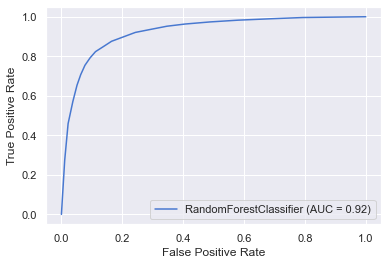

In [ ]:
plot_roc_curve(model, X_valid, y_valid)
plt.show()

This is _almost_ what we need, except that we need to introduce weights, as described in the competition's evaluation:

> The evaluation metric for this competition is Weighted Area Under the ROC Curve. The ROC curve is divided into sections based on the True Positive Rate (TPR). To calculate the total area, multiply the area with TPR in [0., 0.2] by weight 2.0, the area with TPR in [0.2, 0.4] by 1.5, the area with TPR [0.4, 0.6] with weight 1.0, and the area with TPR [0.6, 0.8] with weight 0.5. Anything above a TPR of 0.8 has weight 0.

<div style="text-align: center">
<img src='./images/weighted_roc.png' width='700'>
<p style="text-align: center;"> <b>Figure reference:</b> https://www.kaggle.com/c/flavours-of-physics/overview/evaluation </p>
</div>

We can evaluate the _weighted_ ROC AUC using the helper functions from the competition ([link](https://github.com/yandexdataschool/flavours-of-physics-start):

In [ ]:
# calculate predictions
preds = model.predict(X_valid)
# evaluate with weighted ROC AUC
roc_auc_truncated(y_valid, preds)

0.9176788124156545

This seems like a decent score for our baseline model, so let's generate predictions on the test set and prepare a Kaggle submission.

## Prepare Kaggle submission

Before we can submit our model's predictions, we need to pass two consistency checks:

**_Real vs simulation test_**
> Since the classifier is trained on a mix of simulated signal and real data background, it is possible to reach a high performance by picking features that are not perfectly modeled in the simulation. We require that the classifier not have a large discrepancy when applied to real and simulated data.
>
> To verify this, we use a control channel, Ds → φπ, that has a similar topology as the signal decay, τ → 3μ. Ds → φπ is a much more well-known, well-observed behavior, as it happens more frequently. We provide both data and simulation samples for this decay, to which the classifier is applied. A Kolmogorov–Smirnov (KS) test is used to evaluate the differences between the classifier distribution on each sample.
>
> Ds → φπ data is not included in the training set. This control channel data is used purely in the test set as "ignored" data, meaning that they don’t contribute to the final scoring. The control channel dataset is used purely in Kolmogorov–Smirnov test. We require the KS-value of the test to be smaller than 0.09. Only when a submission can pass the agreement test on these ignored data, we can then regard the predictions as valid, and score on the submission.

**_Mass correlation test_**

> Each particle has its own mass. In an ideal world, one would just the mass of a particle to tell which particle it is. However, in reality, mass is an estimation, and it isn't a feature that scientists trust when building a model. Correlations with mass can cause an artificial signal-like mass peak or lead to incorrect background estimations. 
> 
> The mass column is not included in the test dataset. However, we use the hidden mass information to perform a Cramer-von Mises (cvm) test. This test iteratively compares two distributions of a) predicted values from submission for entire dataset and b) predicted values within a certain mass region in rolling window fashion along the whole mass range. Then we get average value for those checks. Getting similar distributions for all mass sub-regions means that your classifier is not correlated with the mass. Your submission must give a cvm value less than 0.002 to pass the test. 

The datasets needed for these consistency checks can be downloaded as follows:

In [ ]:
download_dataset("tau_decays_check_agreement.csv")
download_dataset("tau_decays_check_correlation.csv")

Dataset already exists at '../data/tau_decays_check_agreement.csv' and is not downloaded again.
Dataset already exists at '../data/tau_decays_check_correlation.csv' and is not downloaded again.


Let's load them as `pandas.DataFrame` objects

In [ ]:
check_agreement = pd.read_csv(DATA / "tau_decays_check_agreement.csv")
check_correlation = pd.read_csv(DATA / "tau_decays_check_correlation.csv")

and include the new features

In [ ]:
check_agreement = add_features(check_agreement)
check_correlation = add_features(check_correlation)

In [ ]:
def run_consistency_tests(fitted_model, X):
    # exclude target from evaluation
    cols_to_keep = X.columns
    
    agreement_probs = model.predict_proba(check_agreement[cols_to_keep])[:, 1]
    print("Checking agreement...")
    ks = compute_ks(
        agreement_probs[check_agreement["signal"] == 0],
        agreement_probs[check_agreement["signal"] == 1],
        check_agreement[check_agreement["signal"] == 0]["weight"].values,
        check_agreement[check_agreement["signal"] == 1]["weight"].values,
    )
    print(f"KS metric {ks:.3},  {ks < 0.09}")

    correlation_probs = model.predict_proba(check_correlation[cols_to_keep])[:, 1]
    print("Checking correlation...")
    cvm = compute_cvm(correlation_probs, check_correlation["mass"])
    print(f"CvM metric {cvm:.3f}, {cvm < 0.002}")

In [ ]:
run_consistency_tests(model, X)

Checking agreement...
KS metric 0.0449,  True
Checking correlation...
CvM metric 0.002, True


Our model passes the tests, so let wrap up by generating the predictions on the test set:

In [ ]:
# score 0.97514 on public leaderboard
test_probs = model.predict_proba(test[cols_to_keep])[:, 1]

submission = pd.DataFrame({"id": test["id"], "prediction": test_probs})
submission.to_csv(DATA / "rf_submission.csv", index=False)

## Exercise